## CIFAR10 Dataset 시각화

In [16]:
import os, copy
root_dir = "/content/MixMatch" # PROJECT Directory
data_dir = os.path.join(root_dir, 'data') # Data Directory
os.makedirs(data_dir, exist_ok=True)

#### 필요한 패키지 부르기

In [17]:
import torch
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

#### torchvision.datasets.CIFAR10 다운로드 및 시각화
#### 예제 이미지 시각화

In [18]:
transform = transforms.Compose(
    [
      transforms.ToTensor(),
      transforms.Normalize(mean=(0.4914, 0.4822, 0.4465),
                           std=(0.2471, 0.2345, 0.2616))
    ]
)

batch_size = 4

In [19]:
train_set = torchvision.datasets.CIFAR10(root=data_dir, train=True,
                                        download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                           shuffle=True, num_workers=2) # DataLoader는 batch_size만큼 데이터를 메모리에 Load하는 역할
                                                                        # Load: 데이터를 RAM에 올려 놓고 연산가능하도록 하는 작업

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


In [20]:
def visualization(img,
                  m=(0.4914, 0.4822, 0.4465),
                  std=(0.2471, 0.2345, 0.2616)):
  for i in range(3):
    img[i, :, :] = img[i, :, :] * std[i] + m[i]
  
  img_np = img.numpy()
  plt.figure(figsize=(10, 10))
  plt.imshow(np.transpose(img_np, (1, 2, 0)))

#### Python 내장함수인 next(), iter() 에 대해 알아보기
##### iter는 반복 가능한 객체(ex, list())에서 iterator를 반환
##### next는 반복 가능한 객체에서 iterator 값을 순차적으로 반환

In [21]:
a = ['1905', '2002', '2012', '2019', '2022']
print(a)

['1905', '2002', '2012', '2019', '2022']


In [22]:
it = iter(a)
next(it)

'1905'

In [23]:
next(it)

'2002'

#### 학습용 이미지를 무작위로 가져오기

In [24]:
iter_data = iter(train_loader) # 데이터를 무작위로 Load해주는 DataLoader -> 반복가능한 객체
imgs, labels = iter_data.next() # 무작위 순서 내 다음 순서를 반환하는 역할

In [25]:
imgs.size() # ToTensor(): (H: 이미지 높이, W:이미지 너비, C: 채널 수-일반적인 이미지는 3 -> CHW 로 변경)

torch.Size([4, 3, 32, 32])

In [26]:
labels.size()

torch.Size([4])

In [27]:
labels

tensor([5, 2, 8, 1])

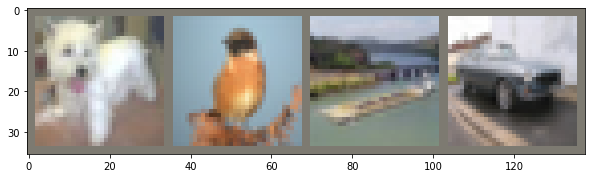

In [28]:
visualization(torchvision.utils.make_grid(imgs))

In [15]:
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

plane dog   horse horse


## Data Augmentation and Two augmenations

#### torchvision transform documentation
#### https://pytorch.org/vision/stable/transforms.html

In [29]:
class Transform_Twice:
    def __init__(self, transform):
        self.transform = transform
    
    def __call__(self, img):
        out1 = self.transform(img)
        out2 = self.transform(img)
        return out1, out2

In [30]:
twice_transform = transforms.Compose([
    transforms.ColorJitter(brightness=0.5, hue=0.3),
    transforms.RandomPerspective(distortion_scale=0.4, p=0.5),
    transforms.RandomRotation(degrees=(0, 180)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.4914, 0.4822, 0.4465),
                          std=(0.2471, 0.2345, 0.2616))
])

train_set = torchvision.datasets.CIFAR10(root=data_dir, train=True,
                                        download=True, transform=Transform_Twice(twice_transform))
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                           shuffle=True, num_workers=2) 

Files already downloaded and verified


In [31]:
iter_data = iter(train_loader) # 데이터를 무작위로 Load해주는 DataLoader -> 반복가능한 객체
(imgs_aug1, imgs_aug2), labels = iter_data.next() # 무작위 순서 내 다음 순서를 반환하는 역할

In [32]:
imgs_aug1.size()

torch.Size([4, 3, 32, 32])

In [33]:
imgs_aug2.size()

torch.Size([4, 3, 32, 32])

In [34]:
labels.size()

torch.Size([4])

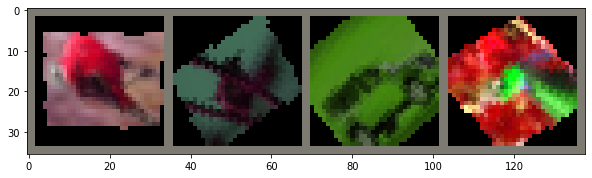

In [35]:
visualization(torchvision.utils.make_grid(imgs_aug1))

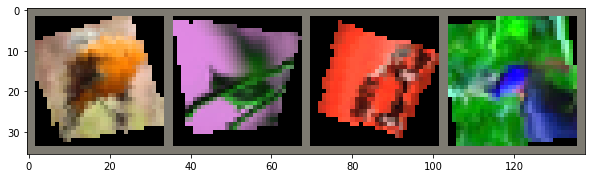

In [36]:
visualization(torchvision.utils.make_grid(imgs_aug2))

## MixUp algorithm (https://arxiv.org/abs/1710.09412)
#### single labels to one-hot encoding

In [37]:
labels

tensor([2, 2, 1, 2])

In [38]:
labels_onehot = torch.zeros(labels.size(0), 10).scatter_(1, labels.view(-1,1).long(), 1)

In [39]:
labels_onehot

tensor([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]])

#### MixUp with imgs_aug1 and imgs_aug2
#### imgs aug2 are randomly permuted

In [40]:
l_mixup = np.random.beta(0.75, 0.75)
l_mixup = max(l_mixup, 1-l_mixup)
print(l_mixup)


0.9008457875391125


In [41]:
B = imgs_aug2.size(0)
random_idx = torch.randperm(B)

imgs_aug2 = imgs_aug2[random_idx, :, :, :]
labels_aug2 = copy.deepcopy(labels_onehot)

In [42]:
labels_aug2 = labels_aug2[random_idx, :]

In [43]:
labels_aug2

tensor([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [44]:
labels_onehot

tensor([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]])

In [45]:
mixed_input = l_mixup*imgs_aug1 + (1-l_mixup)*imgs_aug2
mixed_labels = l_mixup*labels_onehot + (1-l_mixup)*labels_aug2

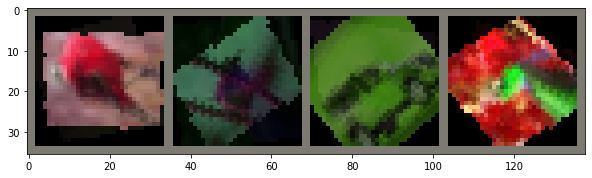

In [46]:
visualization(torchvision.utils.make_grid(mixed_input))

In [47]:
mixed_labels

tensor([[0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.9008, 0.0992, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0992, 0.9008, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000]])

#### MixMatch를 위해 정의한 Normalize, Transpose, pad, RandomPadandCrop, RandomFlip, GaussianNoise 코드 설명
###### https://numpy.org/doc/stable/reference/generated/numpy.pad.html (pad에 대한 자세한 설명)

In [48]:
def Normalize(x, m=(0.4914, 0.4822, 0.4465), std=(0.2471, 0.2345, 0.2616)):
    x, m, std = [np.array(a, np.float32) for a in (x, m, std)]

    x -= m * 255
    x *= 1.0/(255*std)
    return x


def Transpose(x, source='NHWC', target='NCHW'):
    return x.transpose([source.index(d) for d in target])


def pad(x, border=4):
    return np.pad(x, [(0, 0), (border, border), (border, border)], mode='reflect')

In [49]:
class RandomPadandCrop(object):
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size
    
    def __call__(self, x):
        x = pad(x, 4)
        
        old_h, old_w = x.shape[1: ]
        new_h, new_w = self.output_size
        
        top = np.random.randint(0, old_h-new_h)
        left = np.random.randint(0, old_w-new_w)
        
        x = x[:, top:top+new_h, left:left+new_w]
        return x

In [50]:
class RandomFlip(object):
    def __call__(self, x):
        if np.random.rand() < 0.5:
            x = x[:, :, ::-1]
        
        return x.copy()

In [51]:
b = a[::-1] # '::-1' 의 의미: 일종의 순서 뒤집기

In [52]:
b

['2022', '2019', '2012', '2002', '1905']

In [53]:
class GaussianNoise(object):
    def __call__(self, x):
        c, h, w = x.shape
        x += np.random.randn(c, h, w)*0.15
        # 0.15는 사용자가 원하는 수준에서 변경 가능(변경 시에는 직접 테스트해보고 사용하길 권유)
        return x